# Computer simulation of transport networks.
## Auteur: Pinglei He

## O Introduction

### O.0 Motivation
This Jupyter notebook is a recode of a project dedicated to the TIPE exam for the French National Entrance Exam of engineering schools (Concours d’entrée aux Grandes Écoles), in preparation for the Digital Tech Year. The study focuses on the optimization of a transport network, according to the models and the optimization objectives stated below.

Simply put, we study the optimization of the performance of a transport network modeled as a non-oriented graph, with its nodes representing cites and the edges representing whether or not there is an direct route between two cities. The terms "road", "link", "edge" are used interchangeably in this notebook.

### 0.1 The question that we want to answer
Given the positions and the populations of the cities in a region, and a total distance of roads we can build, how do we choose which roads to build.

### O.2 Notations
$V$ : The number of cities

$P_v$: The population of city $v \in ⟦1 ... V⟧$

## I. The Model
### I.1 City distributions
According to the (empirical) [Zipf's Law](https://en.wikipedia.org/wiki/Zipf's_law), the populations counts of the cities in a country follow the Zipf's distribution. That is to say, if we denote $V$ the total number of cities in a country, and $P_1 ... P_V$ the populations of single cities in the descendent order, we have: 
$$ \mathbb{E}(\frac{P_v}{P_1}) = \frac{1}{v} $$

To avoid unneccesary complexities in modeling the cities, we have chosen to omit the edge-case country shapes (such as the oblong Chile), nor do we consider different topologically unrelated/unconnected components of a country(such as Mainland US vs. Alaska) and we set the map to be a square-shape, with the position of the cities to distribute uniformely across the map.



## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import random as rd
import scipy
import scipy.sparse
import copy

The function below produces a 3 $\times$ V matrix, with each column vector representing a city in the form of $[population, x position, y position]$.
$$\begin{pmatrix}
pop_1 & ... & pop_v\\
x_1 & ... & x_v\\
y_1 & ... & y_v
\end{pmatrix}$$

In [3]:
def generate_cities(tot_population, num_city, map_width):
  """Returns a (3, num_city) array representing the cities.
  Each column contains [city_population, x-position, y_position]
  """
  harmonic_arr = np.array([1/v for v in range(1, num_city + 1)])
  harmonic_arr_normalized = harmonic_arr / harmonic_arr.sum()
  population_arr = (tot_population * harmonic_arr_normalized).reshape((1, num_city))
  position_arr = np.random.rand(2, num_city) * map_width
  return np.concatenate((population_arr, position_arr), axis=0)

## I.2 Transport net representation
In order to represent the edges of the graph, we use the dense representation with a boolean matrix. For the edge matrix M, M[i, j] is equal to true if and only if there is a road directly linking i with j. 

In [4]:
def initialize_roads(num_city, prop=0):
  '''
  Returns a boolean array of shape (num_city, num_city) filled with False.

    Parameters:
      num_city (int): the number of cities in the region
  '''
  res = np.zeros((num_city, num_city), dtype=bool)

The function below allows us to visualize the transport network of a region, given information about its population distribution and the roads that are constructed. 

In [5]:
def plot_map(city_arr, road_matrix=None, map_width=None):
  """Plots the map of the region"""
  V = city_arr.shape[1]

  # plots the cities
  plt.scatter(city_arr[1, :], 
              city_arr[2, :], 
              s=city_arr[0, :], 
              c=np.random.rand(V,3)*0.7 + 0.3)
  
  # plots roads, if any
  if road_matrix is not None:
    connected_pairs = [(i, j) for i in range(V) for j in range(i) if road_matrix[i, j]]
    for i, j in connected_pairs:
      plt.plot([city_arr[1, i], city_arr[1, j]], 
              [city_arr[2, i], city_arr[2, j]],
              "g", linestyle="-")
    
  # add padding to the plot
  if map_width is not None:
    padding = map_width/25
    plt.xlim(0 - padding, map_width + padding)
    plt.ylim(0 - padding, map_width + padding)

  # set x and y axis to be equal shape
  plt.gca().set_aspect('equal', adjustable='box')

  plt.show()

Let's visualize a randomly generated map:

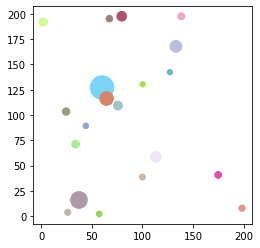

In [6]:
# seeds numpy.random for consistency
np.random.seed(60)

# params
tot_population = 2000
num_city = 20
map_width = 200

# generate a random city
city_arr = generate_cities(tot_population, num_city, map_width)

plot_map(city_arr)

If we compare the map of France to a randomly generated map using the above-mentioned method, we can see that our model produces maps that are quite similar to actual maps:

#### The population distribution of France
<img src="./images/france_city_distribution.png" alt="french_city_distribution" width="60% vw">

#### A randomly generated population distribution
<img src="./images/zipf_generated_distribution.png" alt="simulated_distribution" width="40% vw">

## II Optimization objectives
Before carrying out optimizations, we shall defined the optimization objectives. 

We assume that the probability that one person leaves his city is independent with respect to the city. We thus natually have that, the outgoing flow of population of a given city is proportional to the size of the city:
$$flow_{out}(v) \propto pop_v$$

And when it comes to ingoing population, the more population a city has, the more businesses it has, and the more attractive it is. We may assume that the ingoing population flow is somewhat proportional to its total population. :
$$ flow_{in}(v) \propto pop_v$$

If we ignoge the change in total population of the country, the above two proportionality constants must be equal.
$$ flow_{in}(v) = flow_{out}(v)$$

In this model, we assume that the relative geometrical distance between two cities does not affect the flow of population between the twto cities:

$$ flow(i, j) \propto pop_{i} \times pop_{j} $$

Since we're modeling the network as a weighted graph, let's define the weights of the edges:

if $M[i,j]$ :   $w(i,j) = d(i, j)$

if $not M[i,j]$ : $w(i,j) = \sigma \times d(i, j)$

The weight of an edge between two nodes (i,j) is defined as the cost for one unit of population to go from city i to city j if they were to follow the straight line between the two cities(and vice versa). If there is a road between the two, we set it to be the geometric distance between the two cities. If there isn't one, we penalize the travel cost by multiply the distance with a smoothing constant $\sigma >> 1$to avoid infinities (which would be problematic for optimizations). Let's say that between two cities, there is no direct road. We suppose that traveling between the two cities would be sigma times more difficult than if there was a road (instead of considering that such a scenario is impossible).

When one travels from a city i to a city j, the cost of the travel depends of the path that the person follows. Thus we define the weight of a path to be the sum of the weights of the roads belonging to the path:

The weight of a path:
$$ w(v_1, v_2 ... v_p) = \sum_{k=1}^{p-1}w(v_k, v_k+1) $$

The distance by road (or graph distance) between two cities:
$$ \delta(i,j) = min_{\text{path between i and j}}(w(path))$$

The optimization objective to minimize is the total cost of transportation for the whole region/country:
$$ cost(M) = \sum_{1 < i, j < V} \delta(i,j) \times flow(i, j)$$

### Graph distance calculation
In order to calculate the $\delta(i,j)$s, we use the Floyd-Warshall algorithm. Since one floyd-warshall takes $O(n^3)$ to run, in order to take advantage of the multiprocessing power of the computer and the speed of a lower-level implementation, we will use the scipy module to do the Floyd-Warshall calculation.

In [7]:

def distance_matrix(city_arr):
  """Returns a matrix representing the geometric distances between cities"""
  V = city_arr.shape[1]
  res = np.zeros((V, V))

  # compute the distance between two cities i and j
  def get_distance(i, j):
    dx = city_arr[1, i] - city_arr[1, j]
    dy = city_arr[2, i] - city_arr[2, j]
    return np.sqrt(dx * dx + dy * dy)

  for i in range(V):
    res[i, i] = 0
    for j in range(i):
      d_ij = get_distance(i, j)
      res[i, j] = d_ij
      res[j, i] = d_ij
  return res

def floyd_warshall(city_arr, road_matrix, sigma=10):
  """Returns a matrix distances the same dimensions as the road_matrix, where
  distances[i,j] = the cost of the shortest path between the city i and city j"""
  V = city_arr.shape[1]
  geo_distance = distance_matrix(city_arr)
  M0 = geo_distance * sigma # matrix of infinities
  M0[road_matrix] = geo_distance[road_matrix]
  return scipy.sparse.csgraph.floyd_warshall(M0, directed=False)

Now let's defined a cost function according to equations above. This function takes in input the delta_map calculated by the floyd_warshall function, where delta_map[i, j] is the path with the lowest weight, and outputs the cost of the transport network. Our objective in the sections below would be to lower the cost function.

In [8]:
def get_pop_flow(city_arr):
  """Returns a matrix pop_flow where pop_flow[i, j] is the product of 
  populations of cities i and j"""
  population_arr = city_arr[[0], :]
  print(population_arr.shape)
  return population_arr * population_arr.T

In [10]:
def cost(city_arr, delta_map, pop_flow=None):
  """Returns the total cost of transportation of the network"""
  if pop_flow is None:
    pop_flow = get_pop_flow(city_arr)
  return (pop_flow * delta_map).sum() / 2

### II.3 Restructuring
The following code block simply encapsulates the code above into a TransportNetwork class, which includes information about the the network, including the positions and the populations of the cities, the map width, and the connections between the cities. We also added some minor helper methods used in algorithms below for better code re-useability and type hint for easier debugging purpopses.

In [68]:
class TransportNetwork():
    
    def __init__(self, tot_population: int, num_city: int, map_width=100, cities=None):
        """
        Randomly generates a square region with its populations following the Zipf's Law.

        Parameters
        ----------
            tot_population : int
                the total population of the region
            num_city : int
                the total number of cities in the region
            map_width : float
                the width of the region  
        """
        self.tot_population = tot_population
        self.num_city = num_city
        self.map_width = map_width
        self.cities =  self.generate_cities() if cities is None else cities
        self.pop_flow = self.get_pop_flow()
        self.roads = self.initialize_roads()
        self.distance_matrix = self.get_distance_matrix()
        self.shortest_path_distances = self.get_shortest_path_distances()
        self.cost = self.calculate_cost()

    def generate_copy(self) -> "TransportNetwork":
        """Returns a deep copy of the network."""
        # return TransportNetwork(tot_population=self.tot_population, 
        #                         num_city=self.num_city,
        #                         map_width=self.map_width,
        #                         cities=self.cities)
        return copy.deepcopy(self)
        
    def generate_cities(self) -> np.array:
        """Randomly generates information about the coordinates and the populations of the cities"""
        harmonic_arr = np.array([1/v for v in range(1, self.num_city + 1)])
        harmonic_arr_normalized = harmonic_arr / harmonic_arr.sum()
        population_arr = (self.tot_population * harmonic_arr_normalized).reshape((1, self.num_city))
        position_arr = np.random.rand(2, self.num_city) * self.map_width
        return np.concatenate((population_arr, position_arr), axis=0)

    def initialize_roads(self) -> np.array:
        """Returns an empty road matrix"""
        res = np.zeros((self.num_city, self.num_city), dtype=bool)

    def get_distance_matrix(self) -> np.array:
        """Returns a distance matrix M where M[i, j] represents the geometric distance between city i and j"""
        res = np.zeros((self.num_city, self.num_city))

        def get_distance(i, j):
            dx = self.cities[1, i] - self.cities[1, j]
            dy = self.cities[2, i] - self.cities[2, j]
            return np.sqrt(dx * dx + dy * dy)

        for i in range(self.num_city):
            res[i, i] = 0
            for j in range(i):
                d_ij = get_distance(i, j)
                res[i, j] = d_ij
                res[j, i] = d_ij
        return res

    def get_pop_flow(self) -> np.array:
        """Returns a matrix pop_flow where pop_flow[i, j] is the product of populations of cities i and j"""
        population_arr = self.cities[[0], :]
        print(population_arr.shape)
        return population_arr * population_arr.T

    def get_shortest_path_distances(self, sigma=10.0) -> np.array:
        """Returns a matrix distance_matrix the same dimensions as the road_matrix, where
        distance_matrix[i,j] is the cost of the shortest path between the city i and city j"""
        M0 = self.distance_matrix * sigma
        M0[self.roads] = self.distance_matrix[self.roads]
        return scipy.sparse.csgraph.floyd_warshall(M0, directed=False)

    def update_shortest_path_distances(self, sigma=10.0) -> None:
        """Updates the shortest path distances of the network using the Floyd-Warshall algorithm"""
        self.shortest_path_distances = self.get_shortest_path_distances(sigma=sigma)

    def calculate_cost(self) -> float:
        """Returns the total cost of transportation of the network"""
        self.update_shortest_path_distances()
        return (self.pop_flow * self.shortest_path_distances).sum() / 2

    def plot_map(self) -> None:
        """Plots the map of the region"""
        V = self.num_city
        city_arr = self.cities
        road_matrix = self.roads
        map_width = self.map_width

        # plots the cities
        plt.scatter(city_arr[1, :], 
                    city_arr[2, :], 
                    s=city_arr[0, :], 
                    c=np.random.rand(V,3)*0.7 + 0.3)
  
        # plots roads, if any
        if road_matrix is not None:
            connected_pairs = [(i, j) for i in range(V) for j in range(i) if road_matrix[i, j]]
            for i, j in connected_pairs:
                plt.plot([city_arr[1, i], city_arr[1, j]], 
                        [city_arr[2, i], city_arr[2, j]],
                        "g", linestyle="-")
    
        # add padding to the plot
        if map_width is not None:
            padding = map_width/25
            plt.xlim(0 - padding, map_width + padding)
            plt.ylim(0 - padding, map_width + padding)

        # set x and y axis to be equal shape
        plt.gca().set_aspect('equal', adjustable='box')

        plt.show()
    
    def add_road(self, i: int, j: int, calculate_cost=True) -> None:
        """Adds a road between city i and city j. 
        If calculate_cost is set to True, update the shortest path distances using Floyd-Warshall"""
        self.roads[i, j] = self.roads[j, i] = True
        if calculate_cost: self.update_shortest_path_distances()

    def remove_road(self, i: int, j: int, calculate_cost=True) -> None:
        """Removes a road between city i and city j. 
        If calculate_cost is set to True, update the shortest path distances using Floyd-Warshall"""
        self.roads[i, j] = self.roads[j, i] = False
        if calculate_cost: self.update_shortest_path_distances()

    def reinitialize(self) -> None:
        """Reinitializes the road matrix to an empty matrix"""
        self.roads = np.zeros((self.num_city, self.num_city), dtype=bool)

    def has_road(self, i: int, j: int):
        """Returns True if there's a straight road between city i and city j, else returns False"""
        return self.roads[i, j]

Let's plot the cities to see what out test exeample looks like.

(1, 30)


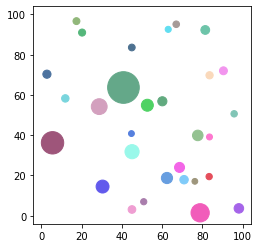

In [91]:
np.random.seed(40)
transport_network_test = TransportNetwork(tot_population=4000, map_width=100, num_city=30)
transport_network_test.plot_map()

## III Algorithms
### III.0 Naive algorithm.
Before trying out sophisticated algorithms, let's first assess the possibility of applying the naive algorithm.

The naive algorithm consists of testing all the possible networks that respect the requirement of the total length of roads, and then choosing the one that is optimal.

The total number of possible edges is $\frac{(V-1) \times (V-1))}{2} = O(V^2)$. Since for each edge, there are two possibilities of whether there is a road or not, the total number of possible configurations is $O(2^{V^2})$. Without even taking into account the calculation of the cost function, the complexity is already exponential, thus we reject the naive algorithm.



## III.1 Covariance Algorithm
The principle of the algorithm goes as follows: We randomly generate the road_matrix respecting the max_road_length requirement, and we save the cost obtained. We repeat the processs a number of times, and we look at the covariance between the presence of a road and the cost obtained. At the end, we keep the roads that are the most negatively-correlated to the cost of the network (since the lower the cost, the better the network).

In [98]:
def random_network_road_contributions(network: TransportNetwork, max_road_length: float, num_iter: int) -> np.ndarray:
    """returns a contributions matrix of shape (num_city, num_city) where at index i,j we have the 
    correlation between the presence of road (i,j) and the performance/efficiency of the transport network"""
    costs = []
    road_matrices = []

    # generate num_iter number of random networks and add save the cost and the graph edge matrices
    for _ in range(num_iter):
        network.roads = network.initialize_roads()
        curr_length = 0
        while curr_length < max_road_length:
            i = np.random.randint(0, network.num_city)
            j = np.random.randint(0, network.num_city)
            if network.roads[i, j]: continue
            curr_length += network.distance_matrix[i, j]
            network.add_road(i, j, calculate_cost=False)
        
        network.update_shortest_path_distances()
        costs.append(network.calculate_cost())
        road_matrices.append(np.copy(network.roads))
    
    # calculate the covariance between the presence of each edge and the cost
    costs = np.array(costs)
    road_matrices = np.array(road_matrices).astype(int)
    #covariance_with_cost[i, j] is the correlation between the presence of edge[i, j] and the cost
    covariance_with_cost = np.zeros(shape=(network.num_city, network.num_city), dtype=np.float64)
    for i in range(network.num_city):
        for j in range(network.num_city):
            covariance_with_cost[i, j] = np.cov(road_matrices[:,i, j], costs)[0, 1]

    #since the lower the cost, the better, we look at minus covariance to measure the contribution of each road
    contribution_matrix = - covariance_with_cost
    return contribution_matrix

def select_best_roads_from_contribution_matrix(network: TransportNetwork, road_contribution_matrix: np.ndarray, max_road_length: float, verbose=True) -> TransportNetwork:
    """Construct the roads that are the most correlated to the performance"""
    # we store (i, j, road_contribution_matrix[i,j] into a list)
    road_contributions = [(i, j, road_contribution_matrix[i, j]) for i in range(network.num_city) for j in range(network.num_city)]
    road_contributions.sort(key=lambda el: el[2])

    # we construct the network until max_road_length is obtained
    # reinitialize the network's roads
    network.roads = network.initialize_roads()
    curr_length = 0
    road_count = 0
    while curr_length < max_road_length:
        (i, j, _) = road_contributions.pop()
        curr_length += network.distance_matrix[i, j]
        road_count += 1
        network.add_road(i, j, calculate_cost=False)
    if verbose: print(f"{road_count} roads have been added to the network. The final cost is {network.calculate_cost()}")
    

Let's see how this algorithm works on our test country/region.
In order to compare the performance of different algorithms on the same test example, we need to use the same population distribution (cities with their positions and their populations) and also the same max_road_length. 

The max_road_length must have a reasonable order of magnitude. We chose to set the max_road_length to be 800 for our example. The thought process behind this arbitrary choice goes as follows: If we had a grid-like network, with four horizontal roads and four vertical roads that spans across the whole country, we would have 2 * 4 * 100 = 800 units of roads.

In [86]:
transport_network_test_cov = transport_network_test.generate_copy()
road_contributions = random_network_road_contributions(transport_network_test_cov, max_road_length=800, num_iter=4000)
select_best_roads_from_contribution_matrix(transport_network_test_cov, road_contribution_matrix=road_contributions, max_road_length=800)

(1, 30)
24 roads have been added to the network. The final cost is 2321138179.648451


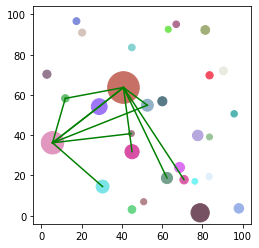

In [87]:
transport_network_test_cov.plot_map()

Observations: The algorithm seems to be linking up only the biggest cities, while ignoring the smaller ones. We may explain this phenomenon by the fact that, by linking up two relatively small cities, the direct decrease of the cost is very small, unless the road between the two cities serve as part of a path which link up more cities. However, since we are limiting the max_road_length during the correlation calculation phase, a road is rarely part of a somewhat important path, since the networks are generated randomly.

In order to increase the probability that a road is part of a longer path, we may choose a different (greater) max_road_length for the correlation calculation and for the actual construction of the network.

Side note:
The total oppulation doesn't actually change the output, since every other parameter being equal, the cost function is simply linear with respect to the square of the total population. 

In [97]:
transport_network_test_cov.distance_matrix.sum()/2 # the total road length if every possible road is constructed

22970.52832332228

In [106]:
road_lengths_for_correlation_calculation = [300, 400, 600, 800, 1000, 
                                            1200, 1500, 2000, 2500, 3000, 
                                            4000, 5000, 7000, 10000, 12000, 
                                            15000, 18000, 20000, 22000] # the road_lengths for the correlation phase to test
network_costs = []

for max_road_length in road_lengths_for_correlation_calculation:
    road_contributions = random_network_road_contributions(transport_network_test_cov, max_road_length=max_road_length, num_iter=500)
    select_best_roads_from_contribution_matrix(transport_network_test_cov, road_contribution_matrix=road_contributions, max_road_length=800, verbose=False)
    network_costs.append(transport_network_test_cov.calculate_cost())

print("Road lengths for correlation calculation: ",road_lengths_for_correlation_calculation)
print("The computed cost of the computed network", network_costs)


Road lengths for correlation calculation:  [300, 400, 600, 800, 1000, 1200, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000, 12000, 15000, 18000, 20000, 22000]
The computed cost of the computed network [2833178526.3558073, 2816491764.080313, 2050938813.8063703, 2029867607.980722, 1847157747.0665116, 1225633833.352193, 1849671214.337126, 758856084.9809874, 830343665.0160887, 893163694.1074042, 646052297.1605186, 496820661.5062486, 496696486.5629004, 394130955.54582816, 400604674.4175261, 365240733.0148619, 365588558.42978144, 358718314.35254353, 356232031.9157354]


Let's confirm our intuition by plotting the network_costs and the road lengths during the correlation calculation phase:

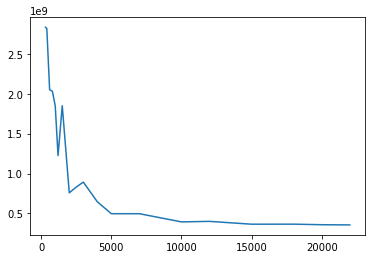

In [107]:

plt.plot(road_lengths_for_correlation_calculation, network_costs)

As we can see, the cost of the final output decreases dramatically with when we increase the allowed length of the roads during the correlation calculation phase, until it enters into a plateau at around 15000). Let's have a look at the best_performing network:

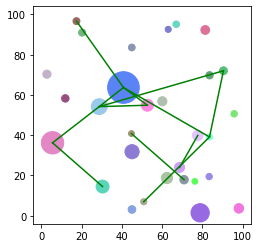

In [108]:
transport_network_test_cov.plot_map()

### Observation
The final output of the best performing graph using the covariance method still does not seem to be satisfying. We suggest that the reason behind this is that the contribution of a road (an edge in the graph) to the performance depends very much on how where the other roads are placed. Since we're taking the edges of the graph that has a strong (negative) correlation with the cost independently, without taking into consideration the other roads that contribute to the correlation, the result is hardly satisfying. In the following section, we're going to construct the network step-by-step, edge-by-edge, road-by-road, and at each step keeping the previouly constructed roads. This ensures that the inter-dependencies of the roads are taken into consideration.

### III.2.a Greedy Algorithm
The greedy algorithm runs as follows:
We start with a graph with no roads constructed. We test out all the possible roads that may be constructed, and choose the one that contributes the most to decreasing the cost function. We repeat the process until no more roads can be constructed without violating the max_road_length constraint.

In [13]:
def greedy_algorithm(transport_network: TransportNetwork, max_road_length: float, verbose=True):
  curr_road_length = 0
  step_count = 0
  cache = {}
  
  curr_cost = transport_network.calculate_cost()

  if verbose:
    print(f"Step 0: The initial cost is {curr_cost}")


  while True: # breaks if adding any more road makes total road length reach the max allowed

    step_count += 1
    curr_best_road = None
    curr_best_cost = np.inf

    for i in range(transport_network.num_city):
      for j in range(i):

        if transport_network.roads[i, j] or transport_network.distance_matrix[i, j] > max_road_length - curr_road_length:
          continue

        transport_network.add_road(i, j)
        new_cost = transport_network.calculate_cost()
        
        if new_cost < curr_best_cost:
          curr_best_cost, curr_best_road = new_cost, (i, j)
        transport_network.remove_road(i,j)
    
    if curr_best_road is None: # no new road found
      print(f"The algorithm finished at step {step_count}")
      print(f"The cost obtained is {curr_cost}")
      break
    
    curr_cost = curr_best_cost
    i, j = curr_best_road
    transport_network.add_road(i, j)
    curr_road_length += transport_network.distance_matrix[i, j]
    if verbose:
      print(f"Step {step_count}: The current cost is {curr_best_cost}")
  
  cache["cost"] = curr_cost

Let's create a network with the greedy algorithm.

In [15]:
transport_network_test_1 = transport_network_test.generate_copy()
greedy_algorithm(transport_network_test_1, max_road_length=800, verbose=True)

(1, 30)
Step 0: The initial cost is 3561299750.406417
Step 1: The current cost is 2883066722.1917543
Step 2: The current cost is 2332812490.3997974
Step 3: The current cost is 2111791637.8542254
Step 4: The current cost is 1905047700.7413461
Step 5: The current cost is 1701025856.4655104
Step 6: The current cost is 1557058590.5492518
Step 7: The current cost is 1416949783.2873492
Step 8: The current cost is 1290142681.3399417
Step 9: The current cost is 1175450687.5132933
Step 10: The current cost is 1072061776.1985168
Step 11: The current cost is 990921793.3193822
Step 12: The current cost is 923246824.021068
Step 13: The current cost is 860540855.2607768
Step 14: The current cost is 804927156.8296181
Step 15: The current cost is 758173052.0453202
Step 16: The current cost is 719846579.3160646
Step 17: The current cost is 685727969.109513
Step 18: The current cost is 652970782.7412229
Step 19: The current cost is 621734317.926429
Step 20: The current cost is 598903164.698286
Step 21: 

We can see that the cost is decreasing with every iteration, with means our algorithm is working. Let's visualize and analyse the result:

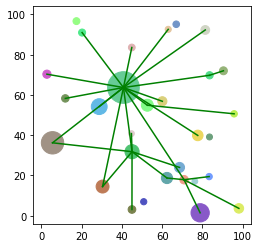

In [16]:
transport_network_test_1.plot_map()

### III.2.b Greedy algorithm II

#### Analysis of the previous algorithm
We notice a problem here: As we can see from the visualization, what our algorithm is essentially doing is linking up the smaller cities to the few bigger ones, resulting in a star-shaped (or multi-cluster star-shaped) structure. The problem is that although some roads between smaller cities have very low costs, they also contribute relatively less to decreasing the cost function. 


#### Greedy algorithm II
We can hope to solve the problem by choosing to create, at each step, not the road that decreasese the cost function the most, but the one that decreases the cost function the most **per unit of length**. We slightly adjust the greedy algorithm:

In [23]:
def greedy_algorithm_2(transport_network: TransportNetwork, max_road_length, sigma=10, verbose=True, report_every=10):
  curr_road_length = 0
  step_count = 0
  cache = {}
  
  curr_cost = transport_network.calculate_cost()
  if verbose:
    print(f"Step 0: The initial cost is {curr_cost}")

  while True: # breaks if no new road that satisfies curr_road_length < max_road_length is found
    step_count += 1
    curr_best_road = None
    # This line is changed:
    curr_best_cost_per_length = -np.inf
    curr_best_cost = np.inf

    for i in range(transport_network.num_city):
      for j in range(i):

        if transport_network.roads[i, j] or transport_network.distance_matrix[i, j] > max_road_length - curr_road_length:
          continue

        transport_network.add_road(i, j)
        new_cost = transport_network.calculate_cost()
        # The line below is changed:
        cost_per_length = (curr_cost - new_cost) / transport_network.distance_matrix[i, j]
        
        if cost_per_length > curr_best_cost_per_length:
          curr_best_cost_per_length, curr_best_road = cost_per_length, (i, j)
          curr_best_cost = new_cost

        transport_network.remove_road(i,j)
    
    if curr_best_road is None:
      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
      print(f"The algorithm finished at step {step_count}")
      print(f"The cost obtained is {curr_cost}")
      break
    
    curr_cost = curr_best_cost
    i, j = curr_best_road
    transport_network.add_road(i, j)
    curr_road_length += transport_network.distance_matrix[i, j]
    if verbose and step_count%report_every==0:
      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
    
  cache["cost"] = curr_cost

We can see that the final cost is dramatically smaller than what we get from the previous implementation. However, it took a lot more steps to train than the previous one. We may explain this by the fact that the second algorithm interests itself a lot more in connections between the neighboring smaller cities, since its goal in each step is not to find the road that has the most **per-unit-length** cost reduction. Let's have a look at the end result here:

In [24]:
transport_network_test_2= transport_network_test.generate_copy()
greedy_algorithm_2(transport_network_test_2, max_road_length=800)

(1, 30)
Step 0: The initial cost is 3561299750.406417
Step 10: The current cost is 1226329556.7755804 Road length 200.4479053494093/800
Step 20: The current cost is 634894351.0534617 Road length 364.9974101250033/800
Step 30: The current cost is 481806172.1495568 Road length 471.48664322732/800
Step 40: The current cost is 396429965.2034892 Road length 722.510507107877/800
Step 44: The current cost is inf Road length 792.902743376531/800
The algorithm finished at step 44
The cost obtained is 390663591.8104032


plot_map(city_arr_test, road_matrix=road_matrix_test, map_width=map_width_test)

We can see that the cost yielded by the new algorithm is significantly smaller than that of the first greedy algorithm. Let's have a look at the new network generated by our algorithm:

The new cost is 390663591.8104032


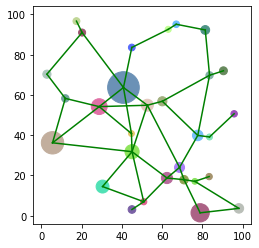

In [19]:
print(f"The new cost is {transport_network_test_2.calculate_cost()}")
transport_network_test_2.plot_map()

## III.3 Backward removal

### Context
In order to find better inspiration for the algorithms, we are going to look at a monocellular creature, called Physarum polycephalum, also commonly known as "the blob". One surprising fact about the creature is that it is a natural path finder. When given food on a flat surface, such as oatmeals for example, where each oatmeal piece is equivalent to a city, with its size proportional to the sizes of the cities, the creature can actually links between the oatmeals and produces a network which is very close to that of an optimized transportation network. More information about this creature can be found <a href="https://www.researchgate.net/figure/Comparison-of-the-Physarum-networks-with-the-Tokyo-rail-network-A-In-the-absence-of_fig2_41111573">in this paper</a>.


Below is a picture showing the blob recreating the Tokyo subway system:

<img src="./images/polysepharum_demonstration.png" width="40% vw" alt="polycepharum-reproducing-tokyo-map"/>

 We decided to buy some of polycephalum and observed the behavior of this creature. Below are images that we've taken for one week of observation.

<img src="./images/observations/day_1.png" width="30% vw" alt="day-1-observation"/>
<img src="./images/observations/day_2.png" width="30% vw" alt="day-2-observation"/>
<img src="./images/observations/day_3.png" width="30% vw" alt="day-3-observation"/>
<img src="./images/observations/day_4.png" width="30% vw" alt="day-4-observation"/>
<img src="./images/observations/day_5.png" width="30% vw" alt="day-5-observation"/>
<img src="./images/observations/day_6.png" width="30% vw" alt="day-6-observation"/>

What we observe is that the blob initially tries to create as many links as possible between the cities, as you can see from the first pictures. After having reached all the cities, the blob actually removes little by little the ones that are less used, only keeping links where the "trafic" is the most affluent, as you can see from the last two pictures.

We've decided to take inspiration directly from the blob, and instead of adding the roads little by little, we start with a dense network, where between each pair of cities there is a direct road. Then, we remove the cities little by little, until the max_road_length restriction is satisfied.

We can imagine at least one case where the backward_removal algorithm is better than the previous greedy algorithm. Let's imagine that we have three cities, with two major cities and one smaller city:

In [25]:
def backward_removal(transport_network: TransportNetwork, max_road_length: float, verbose=True, report_every=10):
  transport_network.roads = np.ones((transport_network.num_city, transport_network.num_city), dtype=bool)
  transport_network.update_shortest_path_distances()
  step_count = 0
  curr_road_length = transport_network.distance_matrix.sum() / 2
  cache = {}
  
  curr_cost = transport_network.calculate_cost()
  if verbose:
    print(f"Step 0: The initial cost is {curr_cost}")

  # We decrease incrementally the current road length
  while curr_road_length > max_road_length:
    step_count += 1
    curr_worst_road = None

    curr_worst_cost_per_length = np.inf
    curr_best_cost = np.inf

    for i in range(transport_network.num_city):
      for j in range(i):

        if not transport_network.roads[i, j]:
          continue

        transport_network.remove_road(i, j)
        new_cost = transport_network.calculate_cost()

        cost_per_length = (new_cost - curr_cost) / transport_network.distance_matrix[i, j]
        
        if cost_per_length < curr_worst_cost_per_length:
          curr_worst_cost_per_length, curr_worst_road = cost_per_length, (i, j)
          curr_best_cost = new_cost

        transport_network.add_road(i, j)
    
    if curr_worst_road is None:
      # After the last road is removed, we continue to add some roads according to the greedy_algorithm, so that the
      # algorithm is not penalized by the fact that the total road length is a bit less than the greedy algorithm.

      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
      print(f"The algorithm finished at step {step_count}")
      print(f"The cost obtained is {curr_cost}")
      break
    
    curr_cost = curr_best_cost
    i, j = curr_worst_road
    transport_network.remove_road(i, j)
    curr_road_length -= transport_network.distance_matrix[i, j]
    if verbose and step_count%report_every==0:
      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
    
  cache["cost"] = curr_cost

In [26]:
transport_network_test_backward_removal = transport_network_test.generate_copy()
backward_removal(transport_network_test_backward_removal, max_road_length=800, report_every=50)

(1, 30)
Step 0: The initial cost is 356129975.0406417
Step 50: The current cost is 356130462.865999 Road length 19197.20326176441/800
Step 100: The current cost is 356136838.30246127 Road length 15779.200725698027/800
Step 150: The current cost is 356167372.38724947 Road length 12404.858209841883/800
Step 200: The current cost is 356273767.6686755 Road length 9149.063336218787/800
Step 250: The current cost is 356593601.5292328 Road length 6345.1202927578925/800
Step 300: The current cost is 357452754.500385 Road length 4059.763240915929/800
Step 350: The current cost is 361901899.7996806 Road length 2087.678766383324/800


Let's see the results:

The new cost of the backward removal algorithm is 387975820.229575


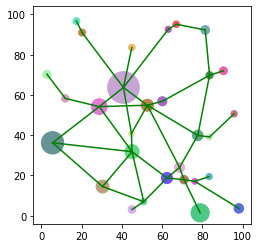

In [22]:
print(f"The new cost of the backward removal algorithm is {transport_network_test_backward_removal.calculate_cost()}")
transport_network_test_backward_removal.plot_map()

In [113]:
def genetic_algorithm(transport_net: TransportNetwork, pond_size=5, expansion_factor=10, max_road_length=800, 
                    num_iter=100, verbose=True, report_every=1, max_num_roads_to_remove=5) -> None:
    pond: list[TransportNetwork] = []
    transport_net = transport_net.generate_copy() # for avoiding side-effects
    transport_net.reinitialize()
    transport_net.cost = transport_net.calculate_cost()

    # initialize pond
    for _ in range(pond_size):
        transport_net_copy = transport_net.generate_copy()
        curr_length = 0
        while curr_length < max_road_length:
            i = np.random.randint(0, transport_net_copy.num_city)
            j = np.random.randint(0, transport_net_copy.num_city)
            if transport_net_copy.has_road(i, j):
                continue
            curr_length += transport_net_copy.distance_matrix[i, j]
            transport_net_copy.add_road(i, j, calculate_cost=False)
        transport_net_copy.cost = transport_net_copy.calculate_cost()
        pond.append(transport_net_copy)
    
    def generate_offsprings(net: TransportNetwork):
        """Given a TransportNetwork instance, randomly change roads to generate modified offsprings in a list and return it."""
        res = [net]
        road_length = (net.roads.astype(int) * net.distance_matrix).sum() / 2 # the road length of the network
        for _ in range(expansion_factor - 1):
            offspring = net.generate_copy()
            curr_length = road_length

            # randomly remove 1 to max_num_roads_to_remove roads
            for road_number in range(np.random.randint(1, max_num_roads_to_remove)):
                while True:
                    i = np.random.randint(offspring.num_city)
                    j = np.random.randint(offspring.num_city)
                    if offspring.has_road(i, j):
                        offspring.remove_road(i, j, calculate_cost=False)
                        curr_length -= offspring.distance_matrix[i, j]
                        break
            
            # randomly add roads until the total road lengths surpass max_road_length
            while curr_length < max_road_length:
                i = np.random.randint(offspring.num_city)
                j = np.random.randint(offspring.num_city)
                if offspring.has_road(i, j):
                    continue
                offspring.add_road(i, j, calculate_cost=False)
                curr_length += offspring.distance_matrix[i, j]
            
            # save the cost of the offspring and add it to the result
            offspring.cost = offspring.calculate_cost()
            res.append(offspring)
    
        return res
            
    # at each iteration, we keep the best ones of the offsprings in the pond
    for iter in range(num_iter):
        offsprings = []
        for net in pond:
            offsprings += generate_offsprings(net)
        offsprings.sort(key=lambda network: network.cost)
        pond = offsprings[:pond_size]
        if verbose and iter%report_every==0:
            print(f"Iteration {iter}.\nThe best offspring has {pond[0].cost} in cost.")
    
    return pond


In [114]:
pond = genetic_algorithm(transport_network_test, expansion_factor=20, pond_size=15, num_iter=2000, report_every=100, max_num_roads_to_remove=10)

Iteration 0.
The best offspring has 1346212605.3234887 in cost.
Iteration 100.
The best offspring has 482901432.38545203 in cost.
Iteration 200.
The best offspring has 440985213.5969232 in cost.
Iteration 300.
The best offspring has 420054582.4052414 in cost.
Iteration 400.
The best offspring has 414600622.3219155 in cost.
Iteration 500.
The best offspring has 404888360.1101517 in cost.
Iteration 600.
The best offspring has 401570099.1025312 in cost.
Iteration 700.
The best offspring has 399306782.4949559 in cost.
Iteration 800.
The best offspring has 397418309.7983674 in cost.
Iteration 900.
The best offspring has 396669891.64221114 in cost.
Iteration 1000.
The best offspring has 396483268.9890292 in cost.
Iteration 1100.
The best offspring has 396021323.86042 in cost.
Iteration 1200.
The best offspring has 394756645.966318 in cost.
Iteration 1300.
The best offspring has 393062257.62707925 in cost.
Iteration 1400.
The best offspring has 391718877.5985999 in cost.
Iteration 1500.
The b

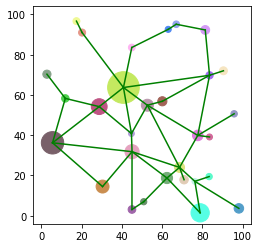

In [117]:
pond[0].plot_map()

In [72]:
[net.calculate_cost() for net in pond]

[3561299750.406417,
 3561299750.406417,
 3561299750.406417,
 3561299750.406417,
 3561299750.406417]

ideas to try:

different sigma for training and for testing.

increase in cost / length

TODO:
complexity analysis